- 1차 EDA & 파생변수 생성 & 2차 EDA
- 모델링 & 가설검증
- 최종 모델 

In [ ]:
!pip install pandas-profiling
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# CRAWLING
import requests
from bs4 import BeautifulSoup

# EDA
from pandas_profiling import ProfileReport

# MODELING
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import xgboost as xgb

from pycaret.classification import *

import warnings
warnings.filterwarnings(action='ignore')

ModuleNotFoundError: ignored

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

# 데이터 불러오기

In [4]:
reg_df = pd.read_csv("reg_train_v4.csv", index_col=0)
#emp_df = pd.read_csv("emp_train_v4.csv", index_col=0)

In [5]:
reg_df.columns

Index(['scd', 'product_name', 'net_order_qty', 'net_order_amt', 'gender',
       'age_grp', 'employee_yn', 'order_date', 'prime_yn', 'total_order_amt',
       'brand', 'festival', 'salary', 'age_gen', 'real_product', 'limit',
       'pre_dcnt', 'colab', 'new_years', 'early_del', 'exclusive', 'dcnt',
       'box', 'mid_cat2', 'expir', 'set', 'event', 'prod_processed',
       'main_cat2', 'matches', 'capacity', 'weight'],
      dtype='object')

In [11]:
col_list = ['age_grp', 'total_order_amt',
       'brand', 'festival', 'salary', 'age_gen', 'limit',
       'pre_dcnt', 'colab', 'new_years', 'early_del', 'exclusive', 'dcnt',
       'box', 'mid_cat2', 'expir', 'set', 'event', 'main_cat2', 'capacity', 'weight']

len(col_list)

21

In [ ]:
reg_df= reg_df.drop(['product_name', 'real_product', 'prod_processed', 'matches', 'pre_dcnt', 'employee_yn'], axis=1) # 일반회원은 선할인X
#emp_df = emp_df.drop(['product_name', 'real_product', 'prod_processed', 'matches', 'employee_yn'], axis = 1)

## 상관관계

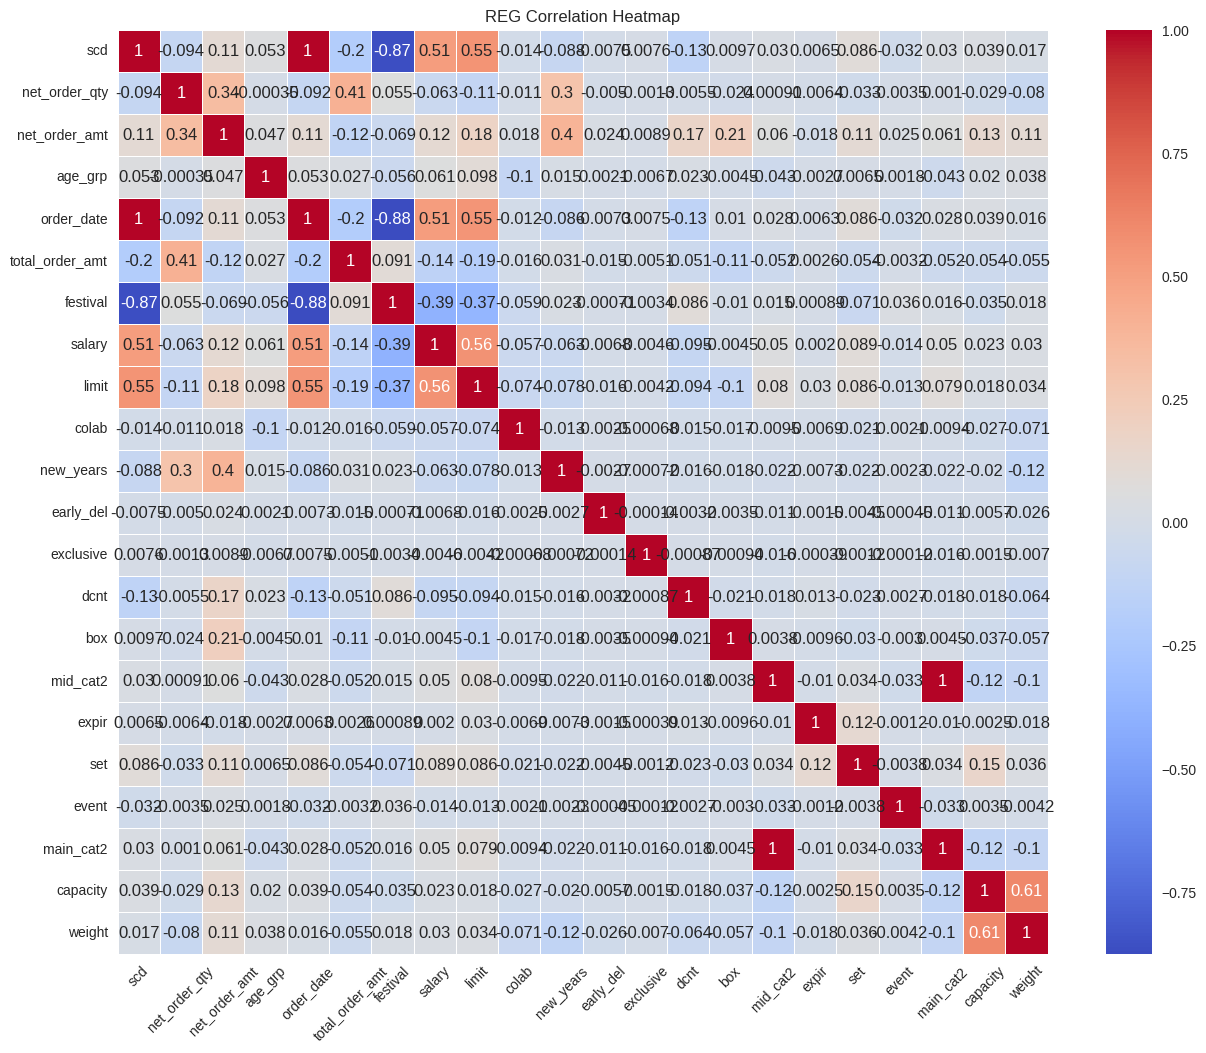

In [ ]:
# Compute the correlation matrix
corr_matrix = reg_df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 12))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, ax=ax)

# Customize the plot
ax.set_title('REG Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

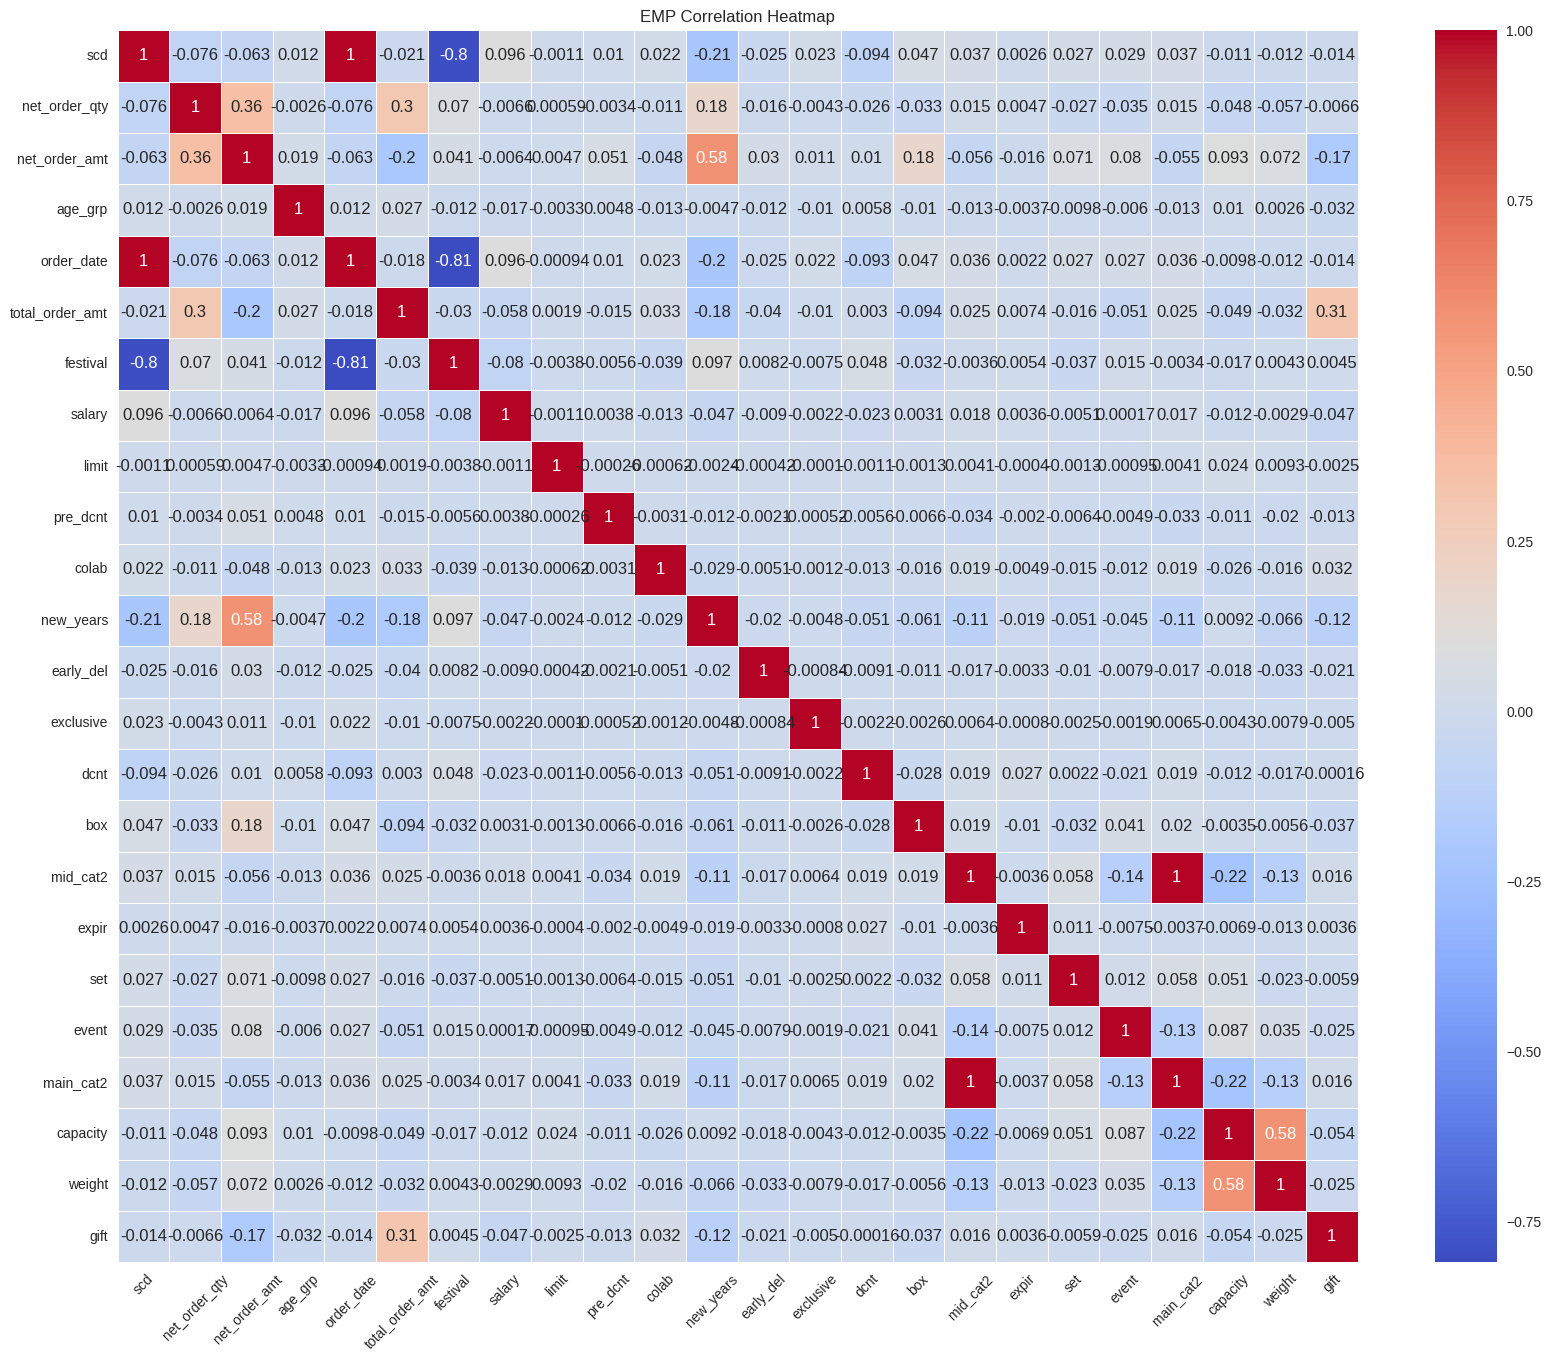

In [ ]:
# Compute the correlation matrix
corr_matrix = emp_df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 16))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, ax=ax)

# Customize the plot
ax.set_title('EMP Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

## EDA REPORT

In [ ]:
profile = ProfileReport(emp_df,
            minimal=False,
            explorative=True,
            title='EMP DATA',
            plot={'histogram': {'bins': 8}},
            pool_size=4,
            progress_bar=False)

# Report 결과 경로에 저장
profile.to_file(output_file="emp_data_eda.html")

In [ ]:
profile = ProfileReport(reg_df,
            minimal=False,
            explorative=True,
            title='REG DATA',
            plot={'histogram': {'bins': 8}},
            pool_size=4,
            progress_bar=False)

# Report 결과 경로에 저장
profile.to_file(output_file="reg_data_eda.html")

# 전반적 모델링

In [ ]:
col2 = ['gender', 'age_gen', 'brand']
dummy_variables = pd.get_dummies(reg_df[col2])
reg_df_encoded1 = pd.concat([reg_df.drop(col2, axis=1), dummy_variables], axis=1)

In [ ]:
X = reg_df_encoded1.drop('prime_yn', axis=1)
y = reg_df_encoded1['prime_yn'].map({'N': 0, 'Y': 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
scaler = MinMaxScaler()

scaled_X_train2 = scaler.fit_transform(X_train)
scaled_X_test2 = scaler.transform(X_test)

In [ ]:
# Initialize the models
xgb = XGBClassifier()
knn = KNeighborsClassifier()
lr = LogisticRegression()
rf = RandomForestClassifier()
lgbm = LGBMClassifier()
catboost = CatBoostClassifier()
dt = DecisionTreeClassifier()
svm = SVC()

# Train the models

lr.fit(scaled_X_train, y_train)

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

svm.fit(scaled_X_train, y_train)
knn.fit(scaled_X_train2, y_train)

xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
catboost.fit(X_train, y_train)

In [ ]:
# Predict on the test set
lr_preds = lr.predict(scaled_X_test)

dt_preds = dt.predict(X_test)
rf_preds = rf.predict(X_test)

svm_preds = svm.predict(scaled_X_test)
knn_preds = knn.predict(scaled_X_test2)

xgb_preds = xgb.predict(X_test)
lgbm_preds = lgbm.predict(X_test)
catboost_preds = catboost.predict(X_test)

In [ ]:
# Calculate F1 score

lr_f1_score = f1_score(y_test, lr_preds)

dt_f1_score = f1_score(y_test, dt_preds)
rf_f1_score = f1_score(y_test, rf_preds)

knn_f1_score = f1_score(y_test, knn_preds)
svm_f1_score = f1_score(y_test, svm_preds)

lgbm_f1_score = f1_score(y_test, lgbm_preds)
catboost_f1_score = f1_score(y_test, catboost_preds)
xgb_f1_score = f1_score(y_test, xgb_preds)

print("Logistic regression:", lr_f1_score)
print("Decision Tree:", dt_f1_score)
print("Random Forest:", rf_f1_score)
print("KNearestNeighbors:", knn_f1_score)
print("Support Vector Machine:", svm_f1_score)
print("Light Gradient Boost:", lgbm_f1_score)
print("Catboost:", catboost_f1_score)
print("XGBoost:", xgb_f1_score)


Logistic regression: 0.5475033141847105
Decision Tree: 0.8064450336528657
Random Forest: 0.7641308967275817
KNearestNeighbors: 0.5913887716336007
Support Vector Machine: 0.5316982878297085
Light Gradient Boost: 0.7794404684450227
Catboost: 0.7768277041470713
XGBoost: 0.8476736775015933


In [ ]:
# Generate classification reports
lr_report = classification_report(y_test, lr_preds)

dt_report = classification_report(y_test, dt_preds)
rf_report = classification_report(y_test, rf_preds)

knn_report = classification_report(y_test, knn_preds)
svm_report = classification_report(y_test, svm_preds)

lgbm_report = classification_report(y_test, lgbm_preds)
catboost_report = classification_report(y_test, catboost_preds)
xgb_report = classification_report(y_test, xgb_preds)

In [ ]:
print("Logistic Regression Classification Report:")
print(lr_report)
print("\n")

print("Decision Tree Classification Report:")
print(dt_report)

print("Random Forest Classification Report:")
print(rf_report)
print("\n")

print("KNN Classification Report:")
print(knn_report)
print("\n")

print("SVM Classification Report:")
print(svm_report)
print("\n")

print("LightGBM Classification Report:")
print(lgbm_report)
print("\n")

print("CatBoost Classification Report:")
print(catboost_report)
print("\n")

print("XGBoost Classification Report:")
print(xgb_report)
print("\n")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.69      0.65      2780
           1       0.59      0.51      0.55      2434

    accuracy                           0.61      5214
   macro avg       0.60      0.60      0.60      5214
weighted avg       0.61      0.61      0.60      5214



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2780
           1       0.80      0.81      0.81      2434

    accuracy                           0.82      5214
   macro avg       0.82      0.82      0.82      5214
weighted avg       0.82      0.82      0.82      5214

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      2780
           1       0.79      0.74      0.76      2434

    accuracy                           0.79      5214
   macro 

# XGBoost

In [ ]:
# Define the parameter grid for grid search -> 다른 시도도 해보기
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    # 'n_estimators': [100, 200, 300]
    'n_estimators': [200, 300, 400]
}

In [ ]:
# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='f1', cv=kfold)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print('final params', grid_search.best_params_)   # 최적의 파라미터 값 출력
print('best score', grid_search.best_score_)      # 최고의 점수

final params {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400}
best score 0.8746914685604021


In [ ]:
# Train the model with the best parameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.4f" % f1)

F1 Score: 0.8936


## Feature Importance 체크

In [ ]:
feature_importance = pd.DataFrame(best_model.feature_importances_.reshape((1, -1)), columns=X_train.columns, index=['feature_importance'])
feat_imp = feature_importance.transpose().sort_values(by='feature_importance', ascending=False)
feat_imp[:20] # 상위 20개

,feature_importance
colab,0.057050
age_gen_2030 F,0.047231
total_order_amt,0.037162
age_gen_4050 M,0.034360
net_order_amt,0.033035
set,0.032860
limit,0.031862
brand_즐거운동행,0.031535
new_years,0.030891
box,0.029435


In [ ]:
fimp = feat_imp.reset_index()
top20 = fimp[:20]

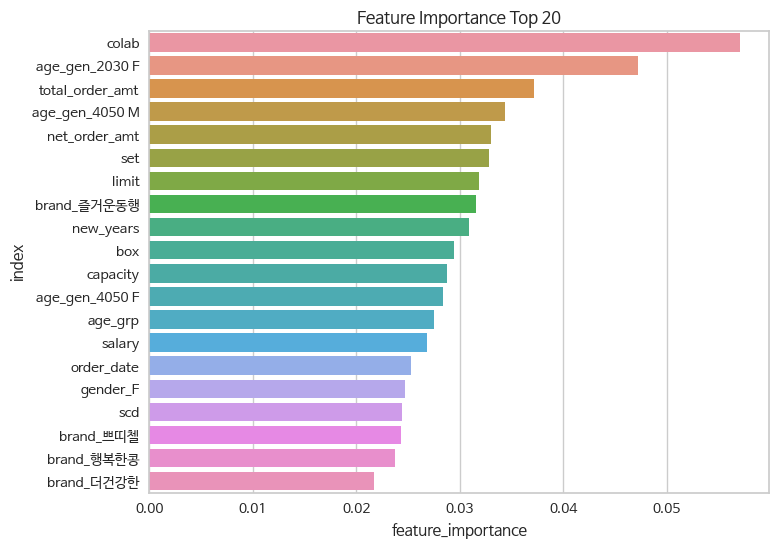

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x= top20['feature_importance'], y= top20['index'])
plt.show()

In [ ]:
feat_imp[-20:] # 하위 20개

,feature_importance
brand_이츠웰,0.0
main_cat2,0.0
brand_정품진,0.0
early_del,0.0
festival,0.0
brand_이너비,0.0
brand_미트마스터 한돈,0.0
brand_아이누리,0.0
brand_산들애,0.0
exclusive,0.0


## 대분류, 중분류 one hot encoding 시도!

In [ ]:
reg_df_tmp = reg_df
reg_df_tmp['mid_cat2'] = reg_df_tmp['mid_cat2'].astype(str)
reg_df_tmp['main_cat2'] = reg_df_tmp['main_cat2'].astype(str)

In [ ]:
col2 = ['gender', 'age_gen', 'brand', 'mid_cat2', 'main_cat2']
dummy_variables = pd.get_dummies(reg_df_tmp[col2])
reg_df_tmp_encoded2 = pd.concat([reg_df_tmp.drop(col2, axis=1), dummy_variables], axis=1)

In [ ]:
reg_df_tmp_encoded2.columns

Index(['scd', 'net_order_qty', 'net_order_amt', 'age_grp', 'order_date',
       'prime_yn', 'total_order_amt', 'festival', 'salary', 'limit',
       ...
       'main_cat2_19', 'main_cat2_20', 'main_cat2_21', 'main_cat2_22',
       'main_cat2_23', 'main_cat2_4', 'main_cat2_5', 'main_cat2_6',
       'main_cat2_7', 'main_cat2_9'],
      dtype='object', length=137)

In [ ]:
X2 = reg_df_tmp_encoded2.drop('prime_yn', axis=1)
y2 = reg_df_tmp_encoded2['prime_yn'].map({'N': 0, 'Y': 1})

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


In [ ]:
# # Create the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier()

# # Perform k-fold cross-validation with grid search
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='f1', cv=kfold)
grid_search.fit(X_train2, y_train2)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_   

In [ ]:
print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_) 

final params {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
best score 0.8210722731593982


In [ ]:
# Train the model with the best parameters
best_model.fit(X_train2, y_train2)

# Predict on the test set
y_pred2 = best_model.predict(X_test2)

# Calculate F1 score
f1 = f1_score(y_test2, y_pred2)
print("F1 Score: %.5f" % f1)

F1 Score: 0.83859


## Feature importance 체크

In [ ]:
feature_importance = pd.DataFrame(best_model.feature_importances_.reshape((1, -1)), columns=X_train2.columns, index=['feature_importance'])
feat_imp = feature_importance.transpose().sort_values(by='feature_importance', ascending=False)
feat_imp[:20] # 상위 20개 

,feature_importance
mid_cat2_2004,0.031696
age_gen_2030 F,0.030715
colab,0.026129
total_order_amt,0.024051
brand_행복한콩,0.022558
age_gen_4050 M,0.020532
mid_cat2_1805,0.020478
net_order_amt,0.020289
new_years,0.019716
age_gen_4050 F,0.019434


In [ ]:
feat_imp[-20:] # 하위 20개

,feature_importance
age_gen_60 FM,0.0
brand_EXCYCLE,0.0
brand_계절밥상,0.0
brand_다시다,0.0
brand_닥터뉴트리,0.0
brand_미트마스터 한돈,0.0
brand_산들애,0.0
brand_아이누리,0.0
brand_이너비,0.0
brand_이츠웰,0.0


# Logistic Regression

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2']
}

# Create the Logistic Regression classifier
logreg = LogisticRegression()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(logreg, param_grid, scoring='f1', cv=kfold)
grid_search.fit(scaled_X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_) 

final params {'C': 0.1, 'penalty': 'l2'}
best score 0.557473429972845


In [ ]:
# Train the model with the best parameters
best_model.fit(scaled_X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(scaled_X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.5f" % f1)

F1 Score: 0.54750


# Decision Tree

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Decision Tree classifier
dt = DecisionTreeClassifier()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(dt, param_grid, scoring='f1', cv=kfold)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_) 

final params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
best score 0.7877236557856959


In [ ]:
# Train the model with the best parameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.5f" % f1)

F1 Score: 0.80319


# RandomForest

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, None]
}

# Create the Random Forest classifier
rf = RandomForestClassifier()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring='f1', cv=kfold)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_)

final params {'max_depth': None, 'n_estimators': 200}
best score 0.7420093247942761


In [ ]:
# Train the model with the best parameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.5f" % f1)

F1 Score: 0.76579


# SVM
- standard scaler
- 개느림 진짜..

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'C': [1.0, 10.0],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

# Create the SVM classifier
svm = SVC()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, scoring='f1', cv=kfold)
grid_search.fit(scaled_X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_) 

In [ ]:
# Train the model with the best parameters
best_model.fit(scaled_X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(scaled_X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.5f" % f1)

# KNN
- MinMaxScale

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Create the KNN classifier
knn = KNeighborsClassifier()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, scoring='f1', cv=kfold)
grid_search.fit(scaled_X_train2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [ ]:
# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_) 

final params {'n_neighbors': 3, 'weights': 'distance'}
best score 0.6262178755433438


In [ ]:
# Train the model with the best parameters
best_model.fit(scaled_X_train2, y_train)

# Predict on the test set
y_pred = best_model.predict(scaled_X_test2)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.5f" % f1)

F1 Score: 0.63644


# CatBoost

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the CatBoost classifier
catboost = CatBoostClassifier()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(catboost, param_grid, scoring='f1', cv=kfold)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_) 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2:	learn: 0.6928680	total: 22.8ms	remaining: 1.5s
3:	learn: 0.6927639	total: 30.5ms	remaining: 1.5s
4:	learn: 0.6926747	total: 38.1ms	remaining: 1.49s
5:	learn: 0.6925933	total: 45.6ms	remaining: 1.48s
6:	learn: 0.6924986	total: 53.1ms	remaining: 1.46s
7:	learn: 0.6924121	total: 60.7ms	remaining: 1.46s
8:	learn: 0.6923424	total: 67.9ms	remaining: 1.44s
9:	learn: 0.6922631	total: 75.5ms	remaining: 1.43s
10:	learn: 0.6921644	total: 83.1ms	remaining: 1.43s
11:	learn: 0.6920790	total: 90.8ms	remaining: 1.42s
12:	learn: 0.6919866	total: 98.3ms	remaining: 1.41s
13:	learn: 0.6918999	total: 106ms	remaining: 1.41s
14:	learn: 0.6918302	total: 113ms	remaining: 1.4s
15:	learn: 0.6917445	total: 124ms	remaining: 1.43s
16:	learn: 0.6916665	total: 142ms	remaining: 1.53s
17:	learn: 0.6915999	total: 149ms	remaining: 1.51s
18:	learn: 0.6915177	total: 157ms	remaining: 1.49s
19:	learn: 0.6914232	total: 164ms	remaining: 1.48s
20:	learn: 0.6913548	total: 171ms	remaining: 1

In [ ]:
# Train the model with the best parameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.5f" % f1)

0:	learn: 0.6846659	total: 36.3ms	remaining: 10.8s
1:	learn: 0.6776049	total: 84ms	remaining: 12.5s
2:	learn: 0.6723151	total: 138ms	remaining: 13.7s
3:	learn: 0.6674345	total: 183ms	remaining: 13.6s
4:	learn: 0.6624550	total: 193ms	remaining: 11.4s
5:	learn: 0.6591160	total: 201ms	remaining: 9.84s
6:	learn: 0.6552863	total: 209ms	remaining: 8.73s
7:	learn: 0.6518020	total: 219ms	remaining: 7.98s
8:	learn: 0.6491681	total: 228ms	remaining: 7.38s
9:	learn: 0.6465944	total: 240ms	remaining: 6.95s
10:	learn: 0.6446399	total: 248ms	remaining: 6.52s
11:	learn: 0.6432673	total: 260ms	remaining: 6.25s
12:	learn: 0.6419260	total: 269ms	remaining: 5.93s
13:	learn: 0.6396261	total: 277ms	remaining: 5.66s
14:	learn: 0.6379362	total: 286ms	remaining: 5.42s
15:	learn: 0.6345407	total: 294ms	remaining: 5.22s
16:	learn: 0.6330892	total: 303ms	remaining: 5.05s
17:	learn: 0.6315178	total: 312ms	remaining: 4.88s
18:	learn: 0.6301297	total: 321ms	remaining: 4.74s
19:	learn: 0.6288785	total: 329ms	remaini

# LGBM

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the LightGBM classifier
lgbm = LGBMClassifier()

# Perform k-fold cross-validation with grid search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, scoring='f1', cv=kfold)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print('final params', grid_search.best_params_) 
print('best score', grid_search.best_score_) 

final params {'learning_rate': 0.1, 'num_leaves': 100}
best score 0.8540645395668751


In [ ]:
# Train the model with the best parameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: %.5f" % f1)

F1 Score: 0.87199


# AUTOML

In [ ]:
clf1 = setup(data=reg_df, target='prime_yn',train_size= 0.8,fold=5)

,Description,Value
0,Session id,1564
1,Target,prime_yn
2,Target type,Binary
3,Target mapping,"N: 0, Y: 1"
4,Original data shape,"(26070, 26)"
5,Transformed data shape,"(26070, 31)"
6,Transformed train set shape,"(20856, 31)"
7,Transformed test set shape,"(5214, 31)"
8,Ordinal features,1
9,Numeric features,22


In [ ]:
best2 = compare_models(sort = 'f1', n_select = 2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8569,0.9325,0.8081,0.8773,0.8412,0.7113,0.7134,4.6880
dt,Decision Tree Classifier,0.8003,0.7995,0.7857,0.7882,0.7869,0.5990,0.5990,1.2840
lightgbm,Light Gradient Boosting Machine,0.8085,0.8912,0.7286,0.8421,0.7812,0.6126,0.6177,1.0820
rf,Random Forest Classifier,0.7786,0.8650,0.7218,0.7886,0.7537,0.5534,0.5553,3.7960
et,Extra Trees Classifier,0.7381,0.8239,0.6889,0.7362,0.7116,0.4723,0.4733,8.8100
qda,Quadratic Discriminant Analysis,0.4742,0.6256,0.9925,0.4714,0.6392,0.0080,0.0383,0.9560
gbc,Gradient Boosting Classifier,0.6840,0.7544,0.5609,0.7054,0.6248,0.3580,0.3651,3.5960
ada,Ada Boost Classifier,0.6307,0.6816,0.5246,0.6275,0.5714,0.2514,0.2546,1.3900
ridge,Ridge Classifier,0.6124,0.0000,0.4946,0.6068,0.5450,0.2135,0.2169,0.4800
lda,Linear Discriminant Analysis,0.6119,0.6542,0.4941,0.6061,0.5444,0.2124,0.2158,1.6040


Processing:   0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
tune_best2 = [tune_model(i, optimize='f1') for i in best2]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6527,0.8803,0.9791,0.5765,0.7257,0.3298,0.4257
1,0.6584,0.8884,0.9760,0.5809,0.7283,0.3402,0.4319
2,0.6639,0.8963,0.9852,0.5841,0.7334,0.3510,0.4484
3,0.6641,0.8894,0.9836,0.5844,0.7332,0.3514,0.4474
4,0.6581,0.8819,0.9862,0.5798,0.7302,0.3405,0.4405
Mean,0.6594,0.8873,0.9820,0.5811,0.7302,0.3426,0.4388
Std,0.0042,0.0057,0.0039,0.0029,0.0029,0.0080,0.0088


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6524,0.7060,0.4545,0.6997,0.5511,0.2878,0.3057
1,0.6524,0.7017,0.4486,0.7030,0.5477,0.2871,0.3063
2,0.6610,0.7167,0.4716,0.7084,0.5663,0.3059,0.3230
3,0.6579,0.7092,0.4257,0.7333,0.5386,0.2960,0.3237
4,0.6485,0.7078,0.5345,0.6533,0.5880,0.2868,0.2912
Mean,0.6544,0.7083,0.4670,0.6995,0.5583,0.2927,0.3100
Std,0.0044,0.0049,0.0368,0.0259,0.0173,0.0074,0.0122


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
blend_best2 = blend_models(estimator_list=tune_best2, fold=5, optimize = 'f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7955,0.9231,0.7819,0.7823,0.7821,0.5895,0.5895
1,0.7801,0.9158,0.7721,0.7624,0.7672,0.5589,0.5590
2,0.8116,0.9339,0.7956,0.8013,0.7985,0.6215,0.6215
3,0.8029,0.9271,0.7798,0.7960,0.7878,0.6039,0.6040
4,0.8113,0.9297,0.7992,0.7988,0.7990,0.6212,0.6212
Mean,0.8003,0.9259,0.7857,0.7882,0.7869,0.5990,0.5990
Std,0.0117,0.0062,0.0101,0.0145,0.0118,0.0233,0.0233


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8569,0.9325,0.8081,0.8773,0.8412,0.7113,0.7134,0.3840
lightgbm,Light Gradient Boosting Machine,0.8085,0.8912,0.7286,0.8421,0.7812,0.6126,0.6177,0.6020
dt,Decision Tree Classifier,0.8003,0.7995,0.7857,0.7882,0.7869,0.5990,0.5990,0.3580
rf,Random Forest Classifier,0.7786,0.8650,0.7218,0.7886,0.7537,0.5534,0.5553,1.5460
et,Extra Trees Classifier,0.7381,0.8239,0.6889,0.7362,0.7116,0.4723,0.4733,1.1300
gbc,Gradient Boosting Classifier,0.6840,0.7544,0.5609,0.7054,0.6248,0.3580,0.3651,0.6540
ada,Ada Boost Classifier,0.6307,0.6816,0.5246,0.6275,0.5714,0.2514,0.2546,0.7740
ridge,Ridge Classifier,0.6124,0.0000,0.4946,0.6068,0.5450,0.2135,0.2169,0.3980
lda,Linear Discriminant Analysis,0.6119,0.6542,0.4941,0.6061,0.5444,0.2124,0.2158,0.7820
nb,Naive Bayes,0.5444,0.5567,0.2732,0.5309,0.3544,0.0589,0.0676,0.4500


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

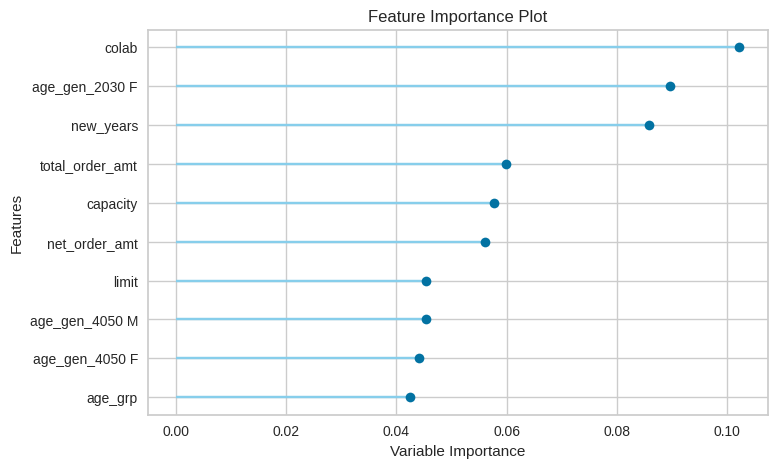

In [ ]:
best_model = compare_models()
plot_model(best_model, plot='feature')

# 변수 선택
- order date 빼볼까?

In [ ]:
reg_df= reg_df.drop(['early_del', 'capacity', 'set', 'expir'], axis=1)

In [ ]:
reg_df[reg_df['colab'] == 1]['prime_yn'].value_counts()

N    206
Y    102
Name: prime_yn, dtype: int64